# Отток клиентов

Из «Бета-Банка» стали уходить клиенты. Каждый месяц. Немного, но заметно. Банковские маркетологи посчитали: сохранять текущих клиентов дешевле, чем привлекать новых.

Нужно спрогнозировать, уйдёт клиент из банка в ближайшее время или нет. Вам предоставлены исторические данные о поведении клиентов и расторжении договоров с банком. 

Построить модель с предельно большим значением *F1*-меры. Чтобы сдать проект успешно, нужно довести метрику до 0.59. Проверьте *F1*-меру на тестовой выборке самостоятельно.

Дополнительно измеряйте *AUC-ROC*, сравнивайте её значение с *F1*-мерой.

Источник данных: [https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling](https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling)

## Подготовка данных

In [29]:
# импортируем все необходимые библиотеки, которые могут нам пригодиться
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report

from sklearn.utils import shuffle
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

In [30]:
# сохраним наш датасет в переменную df и выведим первые пять строк
df = pd.read_csv('/datasets/Churn.csv')
df.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0


In [31]:
# покажем общую информацию о нашей таблице
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           9091 non-null   float64
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB


In [32]:
df.columns

Index(['RowNumber', 'CustomerId', 'Surname', 'CreditScore', 'Geography',
       'Gender', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard',
       'IsActiveMember', 'EstimatedSalary', 'Exited'],
      dtype='object')

<b>Описание данных</b>

Признаки:

- RowNumber — индекс строки в данных
- CustomerId — уникальный идентификатор клиента
- Surname — фамилия
- CreditScore — кредитный рейтинг
- Geography — страна проживания
- Gender — пол
- Age — возраст
- Tenure — сколько лет человек является клиентом банка
- Balance — баланс на счёте
- NumOfProducts — количество продуктов банка, используемых клиентом
- HasCrCard — наличие кредитной карты
- IsActiveMember — активность клиента
- EstimatedSalary — предполагаемая зарплата
- Целевой признак
- Exited — факт ухода клиента

Целевой признак:

- Exited — факт ухода клиента
    

In [33]:
df = df[~df['Tenure'].isna()].reset_index(drop=True)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9091 entries, 0 to 9090
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        9091 non-null   int64  
 1   CustomerId       9091 non-null   int64  
 2   Surname          9091 non-null   object 
 3   CreditScore      9091 non-null   int64  
 4   Geography        9091 non-null   object 
 5   Gender           9091 non-null   object 
 6   Age              9091 non-null   int64  
 7   Tenure           9091 non-null   float64
 8   Balance          9091 non-null   float64
 9   NumOfProducts    9091 non-null   int64  
 10  HasCrCard        9091 non-null   int64  
 11  IsActiveMember   9091 non-null   int64  
 12  EstimatedSalary  9091 non-null   float64
 13  Exited           9091 non-null   int64  
dtypes: float64(3), int64(8), object(3)
memory usage: 994.5+ KB


Изучим корреляции в данных. Так мы можем оценить взаимосвязи в данных и влияние параметров на целевой признак. Для этого воспользуемся методом `sns.pairplot` с параметром `hue`, в который мы передадим целевой признак. Заодно построим корреляционную матрицу и тепловую карту.

In [7]:
#sns.pairplot(df)

In [8]:
corrMatrix = df.corr()
corrMatrix

,RowNumber,CustomerId,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
RowNumber,1.000000,0.004289,0.002330,0.000681,-0.007322,-0.005921,0.009078,0.001248,0.009536,-0.004854,-0.014562
CustomerId,0.004289,1.000000,-0.001610,0.010379,-0.021418,-0.007445,0.014604,-0.019891,0.001499,0.010029,-0.007040
CreditScore,0.002330,-0.001610,1.000000,-0.004504,-0.000062,0.002804,0.011090,-0.003937,0.030947,0.005182,-0.023950
Age,0.000681,0.010379,-0.004504,1.000000,-0.013134,0.031481,-0.031877,-0.014129,0.082269,-0.007037,0.283017
Tenure,-0.007322,-0.021418,-0.000062,-0.013134,1.000000,-0.007911,0.011979,0.027232,-0.032178,0.010520,-0.016761
Balance,-0.005921,-0.007445,0.002804,0.031481,-0.007911,1.000000,-0.301858,-0.019055,-0.003285,0.014351,0.117218
NumOfProducts,0.009078,0.014604,0.011090,-0.031877,0.011979,-0.301858,1.000000,0.005805,0.009084,0.013990,-0.050271
HasCrCard,0.001248,-0.019891,-0.003937,-0.014129,0.027232,-0.019055,0.005805,1.000000,-0.008810,-0.006136,-0.005411
IsActiveMember,0.009536,0.001499,0.030947,0.082269,-0.032178,-0.003285,0.009084,-0.008810,1.000000,-0.020049,-0.155062
EstimatedSalary,-0.004854,0.010029,0.005182,-0.007037,0.010520,0.014351,0.013990,-0.006136,-0.020049,1.000000,0.016029


In [9]:
#sns.heatmap(corrMatrix)

По графикам и тепловой карте можно сделать вывод, что параметрыне завимости друг от друга. 
(можно же сделать такой вывод?:))

## Исследование задачи

Исследуем баланс классов. Обучим модель без учета дисбаланса. В качестве примера воспользуемся моделью логистической регресии.

Чтобы наша модель работала правильно, в обучающем наборе данных должно содержаться одинаковое количество положительных и отрицательных ответов. 

In [10]:
# покажем долю положительного и отрицательного ответа к общему числу данных
df['Exited'].value_counts(normalize=True)

0    0.796062
1    0.203938
Name: Exited, dtype: float64

In [11]:
df

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9086,9995,15719294,Wood,800,France,Female,29,2.0,0.00,2,0,0,167773.55,0
9087,9996,15606229,Obijiaku,771,France,Male,39,5.0,0.00,2,1,0,96270.64,0
9088,9997,15569892,Johnstone,516,France,Male,35,10.0,57369.61,1,1,1,101699.77,0
9089,9998,15584532,Liu,709,France,Female,36,7.0,0.00,1,0,1,42085.58,1


In [34]:
df = df.drop(columns=['RowNumber', 'CustomerId', 'Surname'])

In [37]:
df

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Geography_Germany,Geography_Spain,Gender_Male
0,619,42,2.0,0.00,1,1,1,101348.88,1,0,0,0
1,608,41,1.0,83807.86,1,0,1,112542.58,0,0,1,0
2,502,42,8.0,159660.80,3,1,0,113931.57,1,0,0,0
3,699,39,1.0,0.00,2,0,0,93826.63,0,0,0,0
4,850,43,2.0,125510.82,1,1,1,79084.10,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...
9086,800,29,2.0,0.00,2,0,0,167773.55,0,0,0,0
9087,771,39,5.0,0.00,2,1,0,96270.64,0,0,0,1
9088,516,35,10.0,57369.61,1,1,1,101699.77,0,0,0,1
9089,709,36,7.0,0.00,1,0,1,42085.58,1,0,0,0


In [36]:
# прежде чем построить модель, необходимо преобразовать категориальные данные, разделить их на обучающую и тестовую выборку, а также привести к общему масштабу
df = pd.get_dummies(df, drop_first=True)

Разделим исходные данные на обучающую, валидационную и тестовую выборки по соотношении 3:1:1 (60%:20%:20%). Для этого воспользуемся функцией `train_test_split` из модуля `sklearn.model_selection`.

Функция `train_test_split()` возвращает только два новых набора данных — обучающий и валидационный (или тестовый). А нам нужно поделить наши данные на три части, поэтому поступим cледующим образом.
Сначала воспользуемся функцией `train_test_split()`, чтобы извлечь обучающую (df_train) и временную выборки (df_temp), а затем временную выборку поделим на две равные части, в которых будут храниться валидационная (df_valid) и тестовая выборка (df_test).

In [14]:
#df_train, df_temp = train_test_split(df, test_size=0.4, random_state=23)

In [15]:
#df_valid = df_temp.iloc[0:int(len(df_temp)/2)]
#df_test = df_temp.iloc[int(len(df_temp)/2):]

In [16]:
# как было раньше
df_train, df_temp = train_test_split(df, test_size=0.4, random_state=23)
print(f"Количество строк в y_train по классам: {np.bincount(df_train['Exited'])}")
print(f"Количество строк в y_test по классам: {np.bincount(df_temp['Exited'])}")

Количество строк в y_train по классам: [4316 1138]
Количество строк в y_test по классам: [2921  716]


In [17]:
# как будет сейчас
df_train, df_temp = train_test_split(df, test_size=0.4, random_state=23, stratify=df['Exited'])
print(f"Количество строк в y_train по классам: {np.bincount(df_train['Exited'])}")
print(f"Количество строк в y_test по классам: {np.bincount(df_temp['Exited'])}")

Количество строк в y_train по классам: [4342 1112]
Количество строк в y_test по классам: [2895  742]


In [18]:
df_valid, df_test = train_test_split(df_temp, test_size=0.5, random_state=23, stratify=df_temp['Exited'])
print(f"Количество строк в y_train по классам: {np.bincount(df_valid['Exited'])}")
print(f"Количество строк в y_test по классам: {np.bincount(df_test['Exited'])}")

Количество строк в y_train по классам: [1447  371]
Количество строк в y_test по классам: [1448  371]


In [19]:
# покажем сколько объектов имеют выборочные датасеты
# в скобках покажем процентное соотношение к общему количеству объектов (таблица df)
print(f'Количество объектов у таблицы df_train: {len(df_train)} ({round(len(df_train)/len(df), 2)})')
print(f'Количество объектов у таблицы df_temp: {len(df_temp)} ({round(len(df_temp)/len(df), 2)})')
print(f'Количество объектов у таблицы df_valid: {len(df_valid)} ({round(len(df_valid)/len(df), 2)})')
print(f'Количество объектов у таблицы df_test: {len(df_test)} ({round(len(df_test)/len(df), 2)})')

Количество объектов у таблицы df_train: 5454 (0.6)
Количество объектов у таблицы df_temp: 3637 (0.4)
Количество объектов у таблицы df_valid: 1818 (0.2)
Количество объектов у таблицы df_test: 1819 (0.2)


In [20]:
features_train = df_train.drop(columns='Exited')
target_train = df_train['Exited']
features_valid = df_valid.drop(columns='Exited')
target_valid = df_valid['Exited']
features_test = df_test.drop(columns='Exited')
target_test = df_test['Exited']

In [21]:
scaler = StandardScaler()
scaler.fit(features_train)
features_train = pd.DataFrame(scaler.transform(features_train), index=features_train.index, columns=features_train.columns)
features_valid = pd.DataFrame(scaler.transform(features_valid), index=features_valid.index, columns=features_valid.columns)
features_test = pd.DataFrame(scaler.transform(features_test), index=features_test.index, columns=features_test.columns)

In [24]:
df_train

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Geography_Germany,Geography_Spain,Gender_Male
5735,575,27,3.0,139301.68,1,1,0,99843.98,0,0,0,1
5405,798,38,4.0,129055.13,1,1,0,157147.59,0,1,0,0
1234,625,26,3.0,130483.95,1,1,0,122810.53,0,1,0,1
4587,832,27,10.0,98590.25,1,1,0,30912.89,0,0,0,0
5198,488,43,10.0,112751.13,1,1,1,28332.00,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...
3889,700,28,3.0,99705.69,2,0,0,146723.72,0,1,0,0
539,687,72,9.0,0.00,1,0,1,69829.40,0,0,0,0
3816,648,36,8.0,146943.38,2,1,1,130041.45,0,0,1,1
7436,722,40,6.0,89175.06,2,0,1,152883.95,0,1,0,0


In [23]:
# создадим модель без учета дисбаланса
model = LogisticRegression(random_state=12345, solver='liblinear')
model.fit(features_train, target_train)
predicted_valid = model.predict(features_valid)
print("F1:", f1_score(target_valid, predicted_valid))

F1: 0.3132530120481927


In [46]:
# используем метод classification_report для отображения точности, полноты и f1-метрики
pd.DataFrame(classification_report(target_valid, predicted_valid, output_dict=True)).transpose()

,precision,recall,f1-score,support
0,0.826730,0.966137,0.891013,1447.000000
1,0.614173,0.210243,0.313253,371.000000
accuracy,0.811881,0.811881,0.811881,0.811881
macro avg,0.720451,0.588190,0.602133,1818.000000
weighted avg,0.783353,0.811881,0.773110,1818.000000


Из всех предоставленных объектов 20 процентов больше не являются клиентами банков. Дисбаланс данных составляет 20% на 80% (1:4). F1-мера меньше допустимого. Чтобы увеличить качество нашей модели, попробуем избавиться от дисбаланса.

## Борьба с дисбалансом

### Взвешивание классов

По умолчанию модель присваивает всем объектам равные веса. Так как наш датасет является несбалансированным, то записям с целевым признаком 1 увеличим веса. Для этого воспользуемся атрибутом `class_weight` в нашей модели.

In [47]:
model = LogisticRegression(random_state=12345, solver='liblinear', class_weight='balanced')
model.fit(features_train, target_train)
predicted_valid = model.predict(features_valid)
print("F1:", f1_score(target_valid, predicted_valid))

F1: 0.49562682215743453


In [48]:
pd.DataFrame(classification_report(target_valid, predicted_valid, output_dict=True)).transpose()

,precision,recall,f1-score,support
0,0.900000,0.721493,0.800921,1447.000000
1,0.387538,0.687332,0.495627,371.000000
accuracy,0.714521,0.714521,0.714521,0.714521
macro avg,0.643769,0.704412,0.648274,1818.000000
weighted avg,0.795422,0.714521,0.738619,1818.000000


Качество модели улучшилось, но все еще имеет невысокую точность. Применим другие методы для увеличения качества нашей модели.

### Увеличение выборки

Создадим функцию upsample, которая будет увеличивать (с помощью дублирование) и перемеивать  записи с редкими целевыми признаками. 

In [49]:
#features_train, features_valid, target_train, target_valid = train_test_split(
#                              features, target, test_size=0.25, random_state=12345)

In [50]:
def upsample(features, target, repeat):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)
    
    features_upsampled, target_upsampled = shuffle(
        features_upsampled, target_upsampled, random_state=12345)
    
    return features_upsampled, target_upsampled


In [51]:
features_upsampled, target_upsampled = upsample(features_train, target_train, 4)
print(target_upsampled.value_counts(normalize=True))

1    0.50603
0    0.49397
Name: Exited, dtype: float64


In [52]:
model = LogisticRegression(random_state=12345, solver='liblinear')
model.fit(features_upsampled, target_upsampled)
predicted_valid = model.predict(features_valid)
print("F1:", f1_score(target_valid, predicted_valid))

F1: 0.4956772334293948


Получили качетсво ниже, чем при сбалансированной выборке. Попробуем заодно сравнить с уменьшением выборки.

### Уменьшение выборки

In [53]:
def downsample(features, target, fraction):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_downsampled = pd.concat(
        [features_zeros.sample(frac=fraction, random_state=12345)] + [features_ones])
    target_downsampled = pd.concat(
        [target_zeros.sample(frac=fraction, random_state=12345)] + [target_ones])
    
    features_downsampled, target_downsampled = shuffle(
        features_downsampled, target_downsampled, random_state=12345)
    
    return features_downsampled, target_downsampled


In [54]:
features_downsampled, target_downsampled = downsample(features_train, target_train, 0.25)

In [55]:
model = LogisticRegression(random_state=12345, solver='liblinear')
model.fit(features_downsampled, target_downsampled)
predicted_valid = model.predict(features_valid)
print("F1:", f1_score(target_valid, predicted_valid))

F1: 0.4966824644549764


Результат также показывает ниже 0.5

### Изменение порога

In [57]:
model = LogisticRegression(random_state=12345, solver='liblinear')
model.fit(features_train, target_train)
probabilities_valid = model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]

for threshold in np.arange(0, 0.3, 0.02):
    predicted_valid = probabilities_one_valid > threshold
    precision = precision_score(target_valid, predicted_valid) 
    recall = recall_score(target_valid, predicted_valid) 
    f1 = f1_score(target_valid, predicted_valid) 
    print("Порог = {:.2f} | Точность = {:.3f}, Полнота = {:.3f}, f1-мера = {:.3f}".format(
        threshold, precision, recall, f1))

Порог = 0.00 | Точность = 0.204, Полнота = 1.000, f1-мера = 0.339
Порог = 0.02 | Точность = 0.204, Полнота = 0.992, f1-мера = 0.338
Порог = 0.04 | Точность = 0.216, Полнота = 0.981, f1-мера = 0.354
Порог = 0.06 | Точность = 0.234, Полнота = 0.962, f1-мера = 0.376
Порог = 0.08 | Точность = 0.256, Полнота = 0.925, f1-мера = 0.401
Порог = 0.10 | Точность = 0.275, Полнота = 0.884, f1-мера = 0.420
Порог = 0.12 | Точность = 0.296, Полнота = 0.863, f1-мера = 0.441
Порог = 0.14 | Точность = 0.312, Полнота = 0.822, f1-мера = 0.453
Порог = 0.16 | Точность = 0.336, Полнота = 0.790, f1-мера = 0.471
Порог = 0.18 | Точность = 0.349, Полнота = 0.744, f1-мера = 0.475
Порог = 0.20 | Точность = 0.380, Полнота = 0.701, f1-мера = 0.493
Порог = 0.22 | Точность = 0.397, Полнота = 0.650, f1-мера = 0.493
Порог = 0.24 | Точность = 0.416, Полнота = 0.612, f1-мера = 0.495
Порог = 0.26 | Точность = 0.425, Полнота = 0.577, f1-мера = 0.490
Порог = 0.28 | Точность = 0.434, Полнота = 0.526, f1-мера = 0.476


Наилучшую точность мы получим при пороге 0.12 (f1 = 0.36).

## Тестирование модели

Теперь постараемся подобрать модель, которая имела бы более точное предсказание. Для этого нам поможет модель случайного леса. С помощью цикла for найдем глубину модели и количество деревьев. Также нужно указать, что мы используем сбалансированную выборку.

In [58]:
for depth in range(12, 16, 1):
    for step in range(180, 200, 10):
        model = RandomForestClassifier(n_estimators=step, max_depth=depth, class_weight='balanced', random_state=12345)
        model.fit(features_train, target_train)
        predictions_train = model.predict(features_train)
        predictions_valid = model.predict(features_valid)
        print(f'f1_score = {f1_score(target_train, predictions_train)}')
        print(f'f1_score = {f1_score(target_valid, predictions_valid)}')
        print(f'depth = {depth} and n_estimators = {step}')
        print('---------------')

f1_score = 0.9325591782045557
f1_score = 0.5993975903614458
depth = 12 and n_estimators = 180
---------------
f1_score = 0.93125
f1_score = 0.6015037593984962
depth = 12 and n_estimators = 190
---------------
f1_score = 0.9659803043867503
f1_score = 0.5886075949367089
depth = 13 and n_estimators = 180
---------------
f1_score = 0.9659498207885305
f1_score = 0.5889763779527559
depth = 13 and n_estimators = 190
---------------
f1_score = 0.9874776386404293
f1_score = 0.5671641791044776
depth = 14 and n_estimators = 180
---------------
f1_score = 0.9874888293118856
f1_score = 0.5676567656765676
depth = 14 and n_estimators = 190
---------------
f1_score = 0.9968623935454952
f1_score = 0.5593220338983051
depth = 15 and n_estimators = 180
---------------
f1_score = 0.9968623935454952
f1_score = 0.5612244897959183
depth = 15 and n_estimators = 190
---------------


In [59]:
model = RandomForestClassifier(n_estimators=190, max_depth=12, class_weight='balanced', random_state=12345)
model.fit(features_train, target_train)
predictions_train = model.predict(features_train)
predictions_test = model.predict(features_test)
print(f'f1_score = {f1_score(target_train, predictions_train)}')
print(f'f1_score = {f1_score(target_test, predictions_test)}')
print(f'depth = {12} and n_estimators = {180}')

f1_score = 0.93125
f1_score = 0.5976676384839651
depth = 12 and n_estimators = 180


In [60]:
# class_weight='balanced'
model = RandomForestClassifier(n_estimators=190, max_depth=12, class_weight='balanced', random_state=12345)
model.fit(features_train, target_train)
predicted_test = model.predict(features_test)
print("F1:", f1_score(target_test, predicted_test))

F1: 0.5976676384839651


In [72]:
target_test

3216    0
8554    0
5091    0
7991    0
1087    0
       ..
2874    0
5048    1
2349    0
7285    0
7787    0
Name: Exited, Length: 1819, dtype: int64

In [73]:
len(predicted_test)

1819

In [63]:
pd.DataFrame(classification_report(target_test, predictions_test, output_dict=True)).transpose()

,precision,recall,f1-score,support
0,0.889628,0.924033,0.906504,1448.000000
1,0.650794,0.552561,0.597668,371.000000
accuracy,0.848268,0.848268,0.848268,0.848268
macro avg,0.770211,0.738297,0.752086,1819.000000
weighted avg,0.840916,0.848268,0.843514,1819.000000


В модели случайного леса при глубине 12 и количество деревьев 180 мы достигаем показатель f1-метрики до 0.59. Обтобразим нашу модель на ROC-кривой и измерим ее относительную площадь (AUC-ROC).

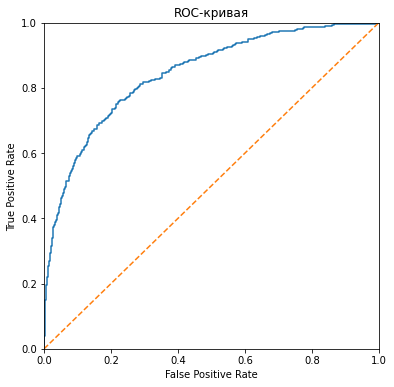

AUC-ROC = 0.8432636892972555


In [64]:
# построим ROC-кривую

probabilities_test = model.predict_proba(features_test)
probabilities_one_test = probabilities_test[:, 1]

fpr, tpr, thresholds = roc_curve(target_test, probabilities_one_test) # < напишите код здесь >

ax=plt.figure(figsize=(6, 6))

# < постройте график >
plt.plot(fpr, tpr)
# ROC-кривая случайной модели (выглядит как прямая)
plt.plot([0, 1], [0, 1], linestyle='--')

# < примените функции plt.xlim() и plt.ylim(), чтобы
#   установить границы осей от 0 до 1 >
plt.ylim([0, 1])
plt.xlim([0, 1])

# < примените функции plt.xlabel() и plt.ylabel(), чтобы
#   подписать оси "False Positive Rate" и "True Positive Rate" >
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

# < добавьте к графику заголовок "ROC-кривая" функцией plt.title() >
plt.title('ROC-кривая')
plt.show()
auc_roc = roc_auc_score(target_test, probabilities_one_test)
print(f'AUC-ROC = {auc_roc}')

Таким образом, финальное тестирование показала нам, что мы мможем добиться необходимой точности при построение модели случайного леса. Также важно учитывать ее параметры: глубину, количество деревьев и баланс данных. 